In [1]:
%pwd

'D:\\Desktop\\Deep Learning\\GAN for Face expression Classification\\Research'

In [2]:
import os

In [3]:
os.chdir("../")

In [4]:
%pwd

'D:\\Desktop\\Deep Learning\\GAN for Face expression Classification'

In [5]:
import logging
from pathlib import Path
logging.basicConfig(
    # filename='extract_data.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [6]:
import os
import shutil
from pathlib import Path
from PIL import Image
import logging

class CopyAndAugmentBalancedDataset:
    def __init__(self, source_directory, copy_directory, target_size=(256, 256)):
        self.source_directory = Path(source_directory)
        self.copy_directory = Path(copy_directory)
        self.target_size = target_size
        self.class_indices = self._get_class_indices()
        # Calculate min_count after obtaining all class indices to ensure it is available when needed
        self.min_count = min(len(files) for files in self.class_indices.values())
        self._log_class_info()

    def _get_class_indices(self):
        """Scan the source directory and map each class to its images."""
        class_indices = {}
        for class_name in os.listdir(self.source_directory):
            class_path = self.source_directory / class_name
            if class_path.is_dir():
                class_indices[class_name] = [str(class_path / fname) for fname in os.listdir(class_path)]
        return class_indices

    def _log_class_info(self):
        """Log information about the classes and their image counts."""
        logging.info(f"Number of unique classes: {len(self.class_indices)}")
        for class_name, files in self.class_indices.items():
            logging.info(f"Count of images in {class_name}: {len(files)}")
        logging.info(f"Minimum frequency among classes: {self.min_count}")

    def _augment_and_copy_image(self, source_path, target_path):
        """Resize image and save to target path."""
        try:
            with Image.open(source_path) as img:
                img_resized = img.resize(self.target_size, Image.Resampling.LANCZOS)
                img_resized.save(target_path)
            logging.debug(f"Image {source_path} resized and copied to {target_path}")
        except Exception as e:
            logging.error(f"Error processing image {source_path}: {e}")

    def copy_and_augment_balanced_dataset(self):
        """Copy and augment a balanced dataset to the copy directory."""
        logging.info("Starting to copy and augment the dataset...")
        for class_name, files in self.class_indices.items():
            copy_path = self.copy_directory / class_name
            copy_path.mkdir(parents=True, exist_ok=True)
            # Ensure we only process up to min_count images per class
            selected_files = files[:self.min_count]
            for file_path in selected_files:
                target_file_path = copy_path / Path(file_path).name
                self._augment_and_copy_image(file_path, target_file_path)
        logging.info(f"Augmented balanced dataset copied to {self.copy_directory}")


In [7]:
source_directory = Path(os.getcwd()) / "Dataset/images" / "train"
copy_directory = Path(os.getcwd()) / "Dataset/images" / "Balanced_train"
augmented_dataset_copier = CopyAndAugmentBalancedDataset(source_directory, copy_directory, target_size=(256, 256))
augmented_dataset_copier.copy_and_augment_balanced_dataset()


2024-04-13 12:16:11 - INFO - Number of unique classes: 7
2024-04-13 12:16:11 - INFO - Count of images in angry: 3993
2024-04-13 12:16:11 - INFO - Count of images in disgust: 436
2024-04-13 12:16:11 - INFO - Count of images in fear: 4103
2024-04-13 12:16:11 - INFO - Count of images in happy: 7164
2024-04-13 12:16:11 - INFO - Count of images in neutral: 4982
2024-04-13 12:16:11 - INFO - Count of images in sad: 4938
2024-04-13 12:16:11 - INFO - Count of images in surprise: 3205
2024-04-13 12:16:11 - INFO - Minimum frequency among classes: 436
2024-04-13 12:16:11 - INFO - Starting to copy and augment the dataset...
2024-04-13 12:16:13 - INFO - Augmented balanced dataset copied to D:\Desktop\Deep Learning\GAN for Face expression Classification\Dataset\images\Balanced_train


# chack databases consistency

In [8]:
import os
import shutil
from pathlib import Path
from PIL import Image
import logging

class CheckBalancedDataset:
    def __init__(self, source_directory, log_class_stats=False):
        self.source_directory = Path(source_directory)
        self.class_indices = self._get_class_indices()
        if log_class_stats:
            self._log_class_info()

    def _get_class_indices(self):
        """Scan the source directory and map each class to its images."""
        class_indices = {}
        for class_name in os.listdir(self.source_directory):
            class_path = self.source_directory / class_name
            if class_path.is_dir():
                class_indices[class_name] = len(os.listdir(class_path))
        return class_indices

    def _log_class_info(self):
        """Log information about the classes and their image counts."""
        logging.info(f"Number of unique classes: {len(self.class_indices)}")
        for class_name, count in self.class_indices.items():
            logging.info(f"Count of images in {class_name}: {count}")

source_directory = Path(os.getcwd()) / "Dataset/images" / "Balanced_train"

log_class_stats = "yes"

balanced_dataset_checker = CheckBalancedDataset(source_directory, log_class_stats=log_class_stats)


2024-04-13 12:16:13 - INFO - Number of unique classes: 7
2024-04-13 12:16:13 - INFO - Count of images in angry: 436
2024-04-13 12:16:13 - INFO - Count of images in disgust: 436
2024-04-13 12:16:13 - INFO - Count of images in fear: 436
2024-04-13 12:16:13 - INFO - Count of images in happy: 436
2024-04-13 12:16:13 - INFO - Count of images in neutral: 436
2024-04-13 12:16:13 - INFO - Count of images in sad: 436
2024-04-13 12:16:13 - INFO - Count of images in surprise: 436


In [9]:
import torch

if torch.cuda.is_available():
    print("CUDA is available! You can use GPU for accelerated computations.")
else:
    print("CUDA is not available. You can use CPU for computations.")


CUDA is not available. You can use CPU for computations.


In [10]:
#Parameters

# Root directory for dataset
dataroot = Path(os.getcwd()) / "Dataset/images" / "Balanced_train"

# Number of workers for dataloader
workers = 3

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 256

# Number of channels in the training images. For color images this is 3
num_channels = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of classes (for example)
num_classes = 7

In [11]:
import torchvision.transforms as transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

In [12]:
#Preparing the dataset and applying transformations to the images in the dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize with single mean and std for grayscale
])
dataset = dset.ImageFolder(root=dataroot, transform=transform)


In [13]:
#Actually loading the data
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [14]:
# Deciding which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cpu')

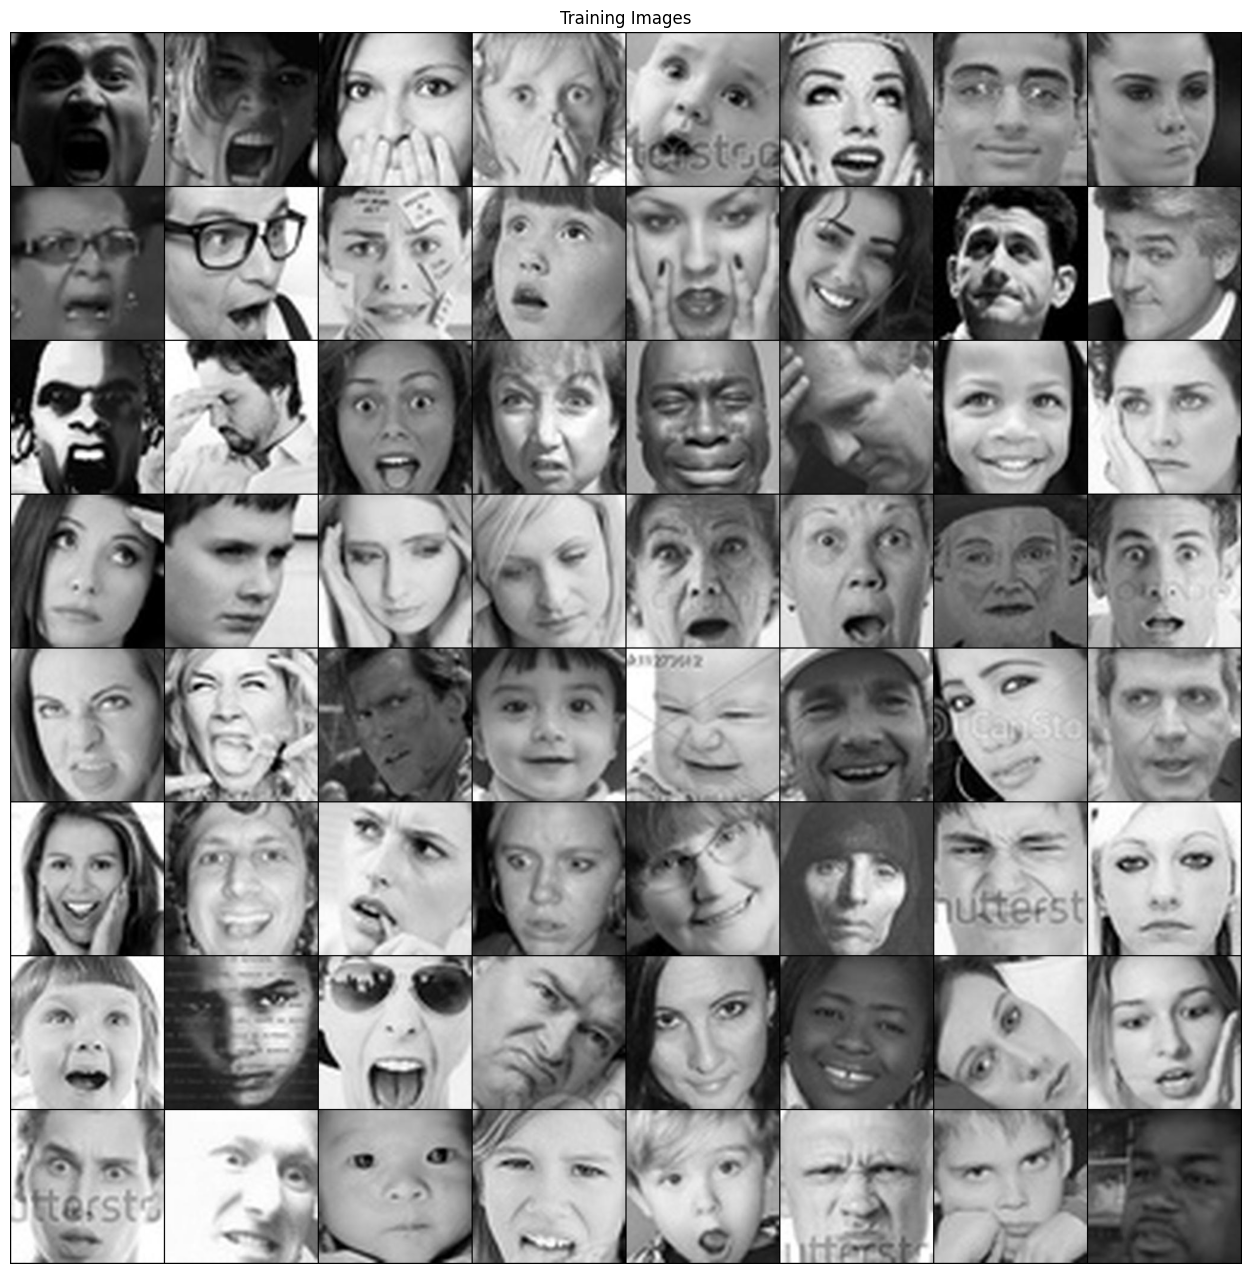

In [15]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Imports

In [16]:
import keras

from keras import layers
from keras import ops
from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio

# Constants and hyperparameters

In [17]:
batch_size = batch_size
num_channels = num_channels
num_classes = num_classes
image_size = image_size
latent_dim = 128

# Loading the Custom dataset and preprocessing it

In [18]:
import numpy as np
import tensorflow as tf

# Assuming you already have your PyTorch dataset defined as 'dataset'

# Separate images and labels
X = []
y = []
for img, label in dataset:
    X.append(img.numpy())  # Convert PyTorch tensor to NumPy array
    y.append(label)  # Append label directly without converting to NumPy array

# Concatenate the lists of arrays to create 'all_digits' and 'all_labels'
all_digits = np.concatenate(X, axis=0)
all_labels = np.array(y)  # Convert list to NumPy array

# Scale the pixel values to [0, 1] range, add a channel dimension to the images,
# and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, image_size, image_size, num_channels))
all_labels = tf.keras.utils.to_categorical(all_labels, num_classes)

# Create TensorFlow Dataset from 'all_digits' and 'all_labels'
tf_dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = tf_dataset.shuffle(buffer_size=len(all_digits)).batch(batch_size)

logging.info(f"Shape of training images: {all_digits.shape}")
logging.info(f"Shape of training labels: {all_labels.shape}")

# Print dataset size
logging.info(f"Number of samples: {len(all_digits)}")

# Print shapes of TensorFlow dataset
for img, label in dataset.take(1):  # Take a single batch for printing shapes
    logging.info(f"Shape of images: {img.shape}")
    logging.info(f"Shape of labels: {label.shape}")


2024-04-13 12:16:38 - INFO - Shape of training images: (3052, 256, 256, 1)
2024-04-13 12:16:38 - INFO - Shape of training labels: (3052, 7)
2024-04-13 12:16:38 - INFO - Number of samples: 3052
2024-04-13 12:16:38 - INFO - Shape of images: (128, 256, 256, 1)
2024-04-13 12:16:38 - INFO - Shape of labels: (128, 7)


https://keras.io/examples/generative/conditional_gan/

# Calculating the number of input channel for the generator and discriminator
In a regular (unconditional) GAN, we start by sampling noise (of some fixed dimension) from a normal distribution. In our case, we also need to account for the class labels. We will have to add the number of classes to the input channels of the generator (noise input) as well as the discriminator (generated image input).

In [19]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
logging.info(f"generator_in_channels are {generator_in_channels} , discriminator_in_channels are {discriminator_in_channels}")

2024-04-13 12:16:38 - INFO - generator_in_channels are 135 , discriminator_in_channels are 8


# Creating the discriminator and generator

In [20]:
num_channels

1

In [21]:
image_size

256

In [22]:
import tensorflow.keras as keras
from tensorflow.keras import layers

# New image dimension
image_size = image_size


# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((image_size, image_size, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

generatorimage_size = int(image_size/4)
# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dense(generatorimage_size * generatorimage_size * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((generatorimage_size, generatorimage_size, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(num_channels, (7, 7), padding="same", activation="tanh"),  # Output 3 channels for RGB
    ],
    name="generator",
)

D:\Desktop\Deep Learning\GAN for Face expression Classification\venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [23]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           4,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,657 (307.25 KB)

 Trainable params: 78,657 (307.25 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 552960)              │      75,202,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 552960)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 135)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 128, 128, 128)       │         276,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 256, 256, 64)        │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 1)         │           3,137 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,613,441 (288.44 MB)

 Trainable params: 75,613,441 (288.44 MB)

 Non-trainable params: 0 (0.00 B)

# Creating a ConditionalGAN model

In [25]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = tf.random.set_seed(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        logging.info(f"Real Images shape: {real_images.shape}")
        logging.info(f"One-hot Labels shape: {one_hot_labels.shape}")

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        logging.info(f"image shape: {image_size}")
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        logging.info(f"num_classes: {num_classes}")
        image_one_hot_labels = ops.reshape(
        image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        logging.info(f"Generated Images shape: {generated_images.shape}")

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        logging.info(f"Generator Loss: {self.gen_loss_tracker.result()}")
        logging.info(f"Discriminator Loss: {self.disc_loss_tracker.result()}")
        
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

# Training the Conditional GAN

In [27]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Fit the model and capture the loss history
history = cond_gan.fit(dataset, epochs=100)

Epoch 1/100


2024-04-13 12:36:19 - INFO - Real Images shape: (None, 256, 256, 1)
2024-04-13 12:36:19 - INFO - One-hot Labels shape: (None, 7)
2024-04-13 12:36:19 - INFO - image shape: 256
2024-04-13 12:36:19 - INFO - num_classes: 7
2024-04-13 12:36:19 - INFO - Generated Images shape: (None, 256, 256, 1)
2024-04-13 12:36:20 - INFO - Generator Loss: Tensor("div_no_nan:0", shape=(), dtype=float32)
2024-04-13 12:36:20 - INFO - Discriminator Loss: Tensor("div_no_nan_1:0", shape=(), dtype=float32)
2024-04-13 12:36:21 - INFO - Real Images shape: (None, 256, 256, 1)
2024-04-13 12:36:21 - INFO - One-hot Labels shape: (None, 7)
2024-04-13 12:36:21 - INFO - image shape: 256
2024-04-13 12:36:21 - INFO - num_classes: 7
2024-04-13 12:36:21 - INFO - Generated Images shape: (None, 256, 256, 1)
2024-04-13 12:36:21 - INFO - Generator Loss: Tensor("div_no_nan:0", shape=(), dtype=float32)
2024-04-13 12:36:21 - INFO - Discriminator Loss: Tensor("div_no_nan_1:0", shape=(), dtype=float32)


24/24 ━━━━━━━━━━━━━━━━━━━━ 624s 26s/step - d_loss: 0.6632 - g_loss: 0.7493 - discriminator_loss: 0.6619 - generator_loss: 0.7440
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 622s 26s/step - d_loss: 0.7213 - g_loss: 0.6726 - discriminator_loss: 0.7336 - generator_loss: 0.6664
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 623s 26s/step - d_loss: 0.6223 - g_loss: 0.8117 - discriminator_loss: 0.6428 - generator_loss: 0.7995
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 622s 26s/step - d_loss: 0.7012 - g_loss: 0.7637 - discriminator_loss: 0.6156 - generator_loss: 0.8956
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 623s 26s/step - d_loss: 0.3021 - g_loss: 1.5426 - discriminator_loss: 0.2657 - generator_loss: 1.6569
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 621s 26s/step - d_loss: 0.4197 - g_loss: 1.4341 - discriminator_loss: 0.3036 - generator_loss: 1.8208
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 624s 26s/step - d_loss: 0.2163 - g_loss: 1.9955 - discriminator_loss: 0.1639 - generator_loss: 2.8184
Epoch 8/100
24/24 ━━━━━━━

In [28]:
from pathlib import Path

# Define the directory to save the models
save_dir = Path(os.getcwd()) / "Model" / "CGAN"

# Ensure the directory exists
save_dir.mkdir(parents=True, exist_ok=True)

# Save the generator and discriminator models
cond_gan.generator.save(save_dir / "generator_model.keras")
cond_gan.discriminator.save(save_dir / "discriminator_model.keras")


# Retraining CGAN

In [29]:
# from pathlib import Path
# import tensorflow as tf
# from keras.models import load_model

# # Define the directory where the models are saved
# save_dir = Path(os.getcwd()) / "Model" / "CGAN"

# # Load the generator and discriminator models
# generator_model_path = save_dir / "generator_model.keras"
# discriminator_model_path = save_dir / "discriminator_model.keras"

# generator = load_model(generator_model_path)
# discriminator = load_model(discriminator_model_path)

# # Compile the loaded generator and discriminator models
# # Make sure to provide the appropriate optimizer and loss function configurations
# generator.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.0003),
#     loss=keras.losses.BinaryCrossentropy(from_logits=True)
# )
# discriminator.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.0003),
#     loss=keras.losses.BinaryCrossentropy(from_logits=True)
# )


In [30]:
# generator.summary()

In [31]:
# discriminator.summary()

In [32]:
# # Reinitialize the conditional GAN with the loaded models
# cond_gan = ConditionalGAN(
#     discriminator=discriminator, generator=generator, latent_dim=latent_dim
# )

# # Compile the conditional GAN
# cond_gan.compile(
#     d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
#     g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
#     loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
# )

# # Retrain the conditional GAN and save the models again
# history = cond_gan.fit(dataset, epochs=2000)

# # Save the generator and discriminator models again
# cond_gan.generator.save(save_dir / "generator_model_retrained.keras")
# cond_gan.discriminator.save(save_dir / "discriminator_model_retrained.keras")

# Plots

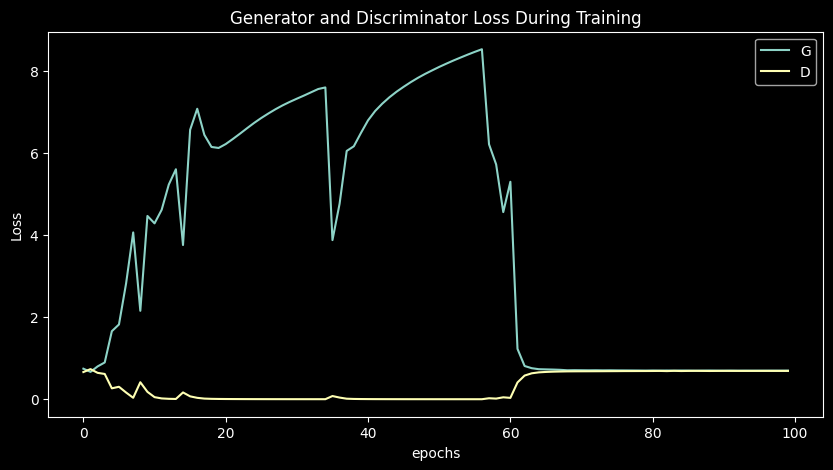

In [33]:
import matplotlib.pyplot as plt
# Save plots
plots_path = Path(os.getcwd()) / "Model" / "CGAN"
plt.style.use('dark_background')

# Extract generator and discriminator loss from the history
G_losses = history.history['generator_loss']
D_losses = history.history['discriminator_loss']

# Plot the generator and discriminator loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(plots_path / "Balanced_CGAN_Generator and Discriminator Loss.png")
plt.show()


# Interpolating between classes with the trained generator

In [34]:
# We first extract the trained generator from our Conditional GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 100 # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # Calculate the interpolation vector between the two labels.
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 0  # @param {type:"slider", min:0, max:9, step:1}
end_class = 6  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 767ms/step



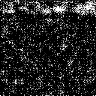

In [35]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1)
embed.embed_file("animation.gif")

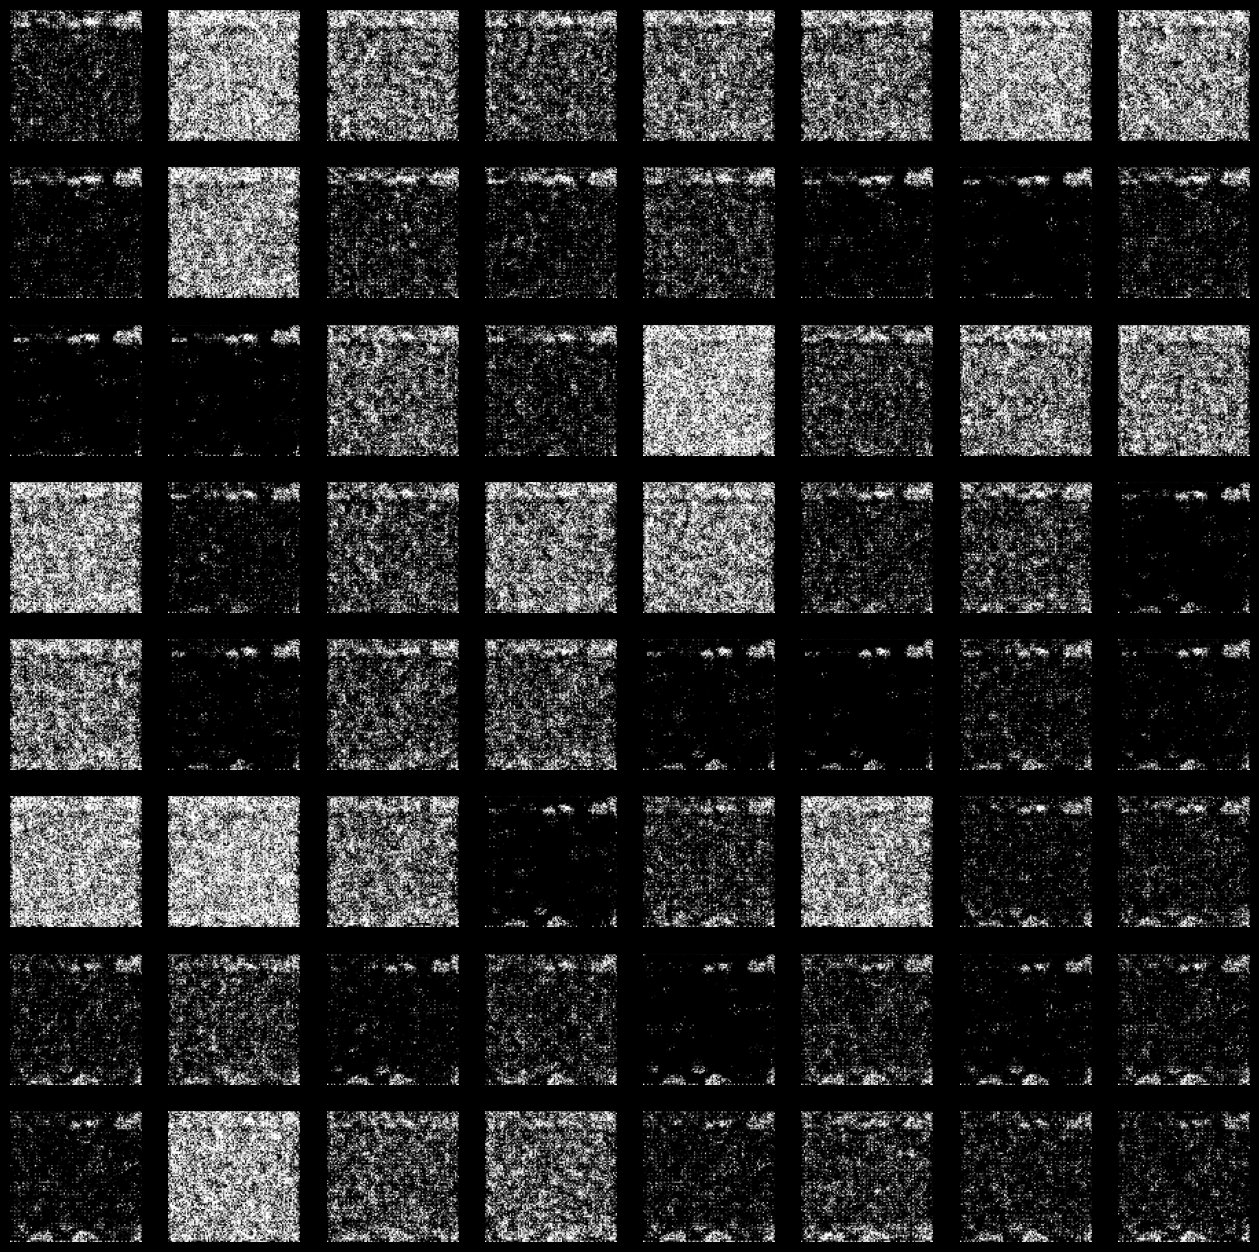

In [36]:
import matplotlib.pyplot as plt

# Assuming converted_images is a list of 64 images

fig, axs = plt.subplots(8, 8, figsize=(16, 16))

for i in range(8):
    for j in range(8):
        index = i * 8 + j
        axs[i, j].imshow(converted_images[index], cmap='gray')
        axs[i, j].axis('off')

plt.show()
